Using TensorFlow backend.


Epoch 1/5
38568/38568 [==============================] - 67s - loss: 0.0208 - val_loss: 0.0178
Epoch 2/5
38568/38568 [==============================] - 63s - loss: 0.0172 - val_loss: 0.0154
Epoch 3/5
38568/38568 [==============================] - 60s - loss: 0.0162 - val_loss: 0.0183
Epoch 4/5
38568/38568 [==============================] - 63s - loss: 0.0156 - val_loss: 0.0145
Epoch 5/5
38568/38568 [==============================] - 64s - loss: 0.0150 - val_loss: 0.0141
dict_keys(['loss', 'val_loss'])


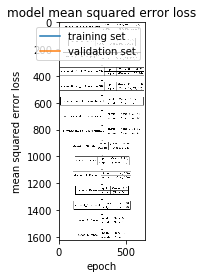

In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
import os
%matplotlib inline

samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        samples.append(row)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)


# plt.imshow()

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for batch_sample in batch_samples:
                # Use 3 cameras
                measurement = float(batch_sample[3])
                measurement_left = measurement + 0.2
                measurement_right = measurement - 0.2
                
                for i in range(3):
                    filename = './data/IMG/'+batch_sample[i].split('/')[-1]
                    image = cv2.imread(filename)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    images.append(image)
                    images.append(cv2.flip(image,1))
                    
                measurements.extend([measurement,
                     measurement*-1.0,
                     measurement_left,
                     measurement_left*-1.0,
                     measurement_right,
                     measurement_right*-1.0])

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D,Convolution2D,Dropout
from keras.layers import MaxPooling2D
from keras.utils.visualize_util import plot

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)


model = Sequential()
model.add(Lambda(lambda x: x /255.0 - 0.5,input_shape=(160, 320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2, 2), activation = 'relu'))
model.add(Convolution2D(36,5,5,subsample=(2,2), activation = 'relu'))
model.add(Convolution2D(48,5,5,subsample=(2,2), activation = 'relu'))
model.add(Convolution2D(64,3,3,activation = 'relu'))
model.add(Convolution2D(64,3,3,activation = 'relu'))

model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples)*6, validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=5, verbose=1)

dict_keys(['loss', 'val_loss'])


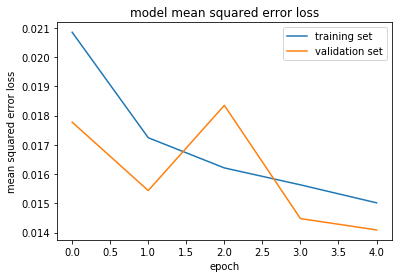

In [12]:

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('./writeup_images/loss.png')

plt.show()


model.save('model.h5')

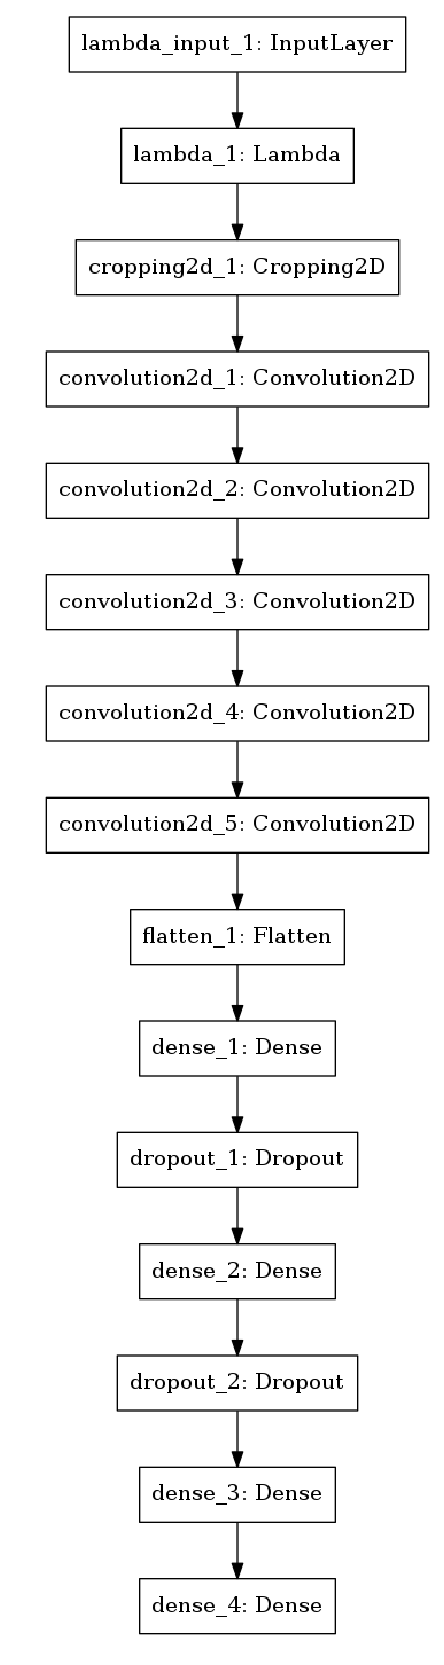

In [11]:
# %matplotlib inline
#print model
plot(model, to_file='./writeup_images/model.png')
model_image = mpimg.imread('./writeup_images/model.png')
plt.figure(figsize=[10, 30])
plt.axis('off')
plt.imshow(model_image) 
plt.show()

In [2]:
import keras
print (keras.__version__)  

1.2.1
